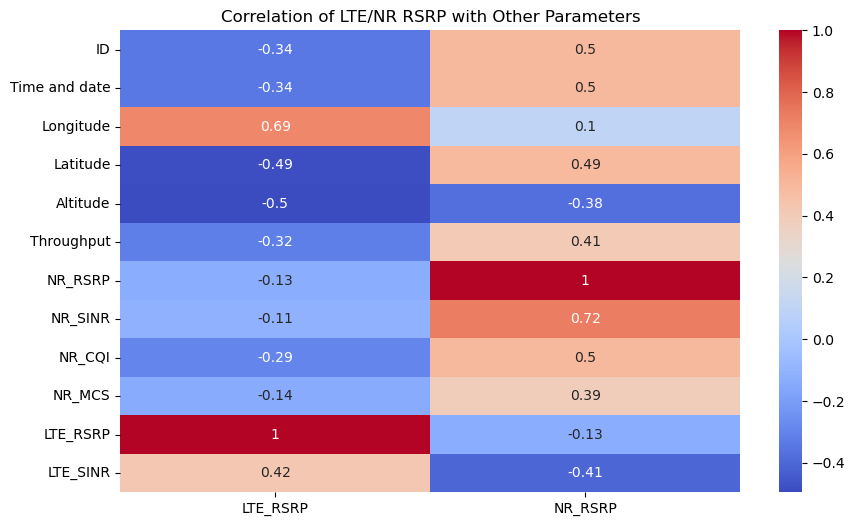

Top correlations with LTE RSRP:
LTE_RSRP         1.000000
Longitude        0.690110
LTE_SINR         0.422069
NR_SINR         -0.112053
NR_RSRP         -0.130825
NR_MCS          -0.139247
NR_CQI          -0.293150
Throughput      -0.315073
Time and date   -0.340100
ID              -0.340101
Latitude        -0.485078
Altitude        -0.495202
Name: LTE_RSRP, dtype: float64

Top correlations with NR RSRP:
NR_RSRP          1.000000
NR_SINR          0.724287
Time and date    0.497636
ID               0.497635
NR_CQI           0.495418
Latitude         0.489683
Throughput       0.409008
NR_MCS           0.386542
Longitude        0.104741
LTE_RSRP        -0.130825
Altitude        -0.377062
LTE_SINR        -0.406853
Name: NR_RSRP, dtype: float64


In [2]:
# LTE/NR RSRP Factor Analysis for yaw45 Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "C:/Users/karth/Downloads/Ericsson_Amir/Dryad/"

def load_data(filename):
    df = pd.read_csv(DATA_PATH + filename)
    df["Time and date"] = pd.to_datetime(df["Time and date"], errors="coerce")
    return df

def round_time(df):
    df["Time and date"] = df["Time and date"].dt.round("1s")
    return df


throughput_45 = round_time(load_data('yaw45/input_throughput_with_header.csv'))
LTE_RSRP_45 = round_time(load_data('yaw45/inputf1_rsrp_with_header.csv'))
LTE_SINR_45 = round_time(load_data('yaw45/inputf1_sinr_with_header.csv'))
NR_RSRP_45 = round_time(load_data('yaw45/inputf2_rsrp_with_header.csv'))
NR_SINR_45 = round_time(load_data('yaw45/inputf2_sinr_with_header.csv'))
NR_CQI_45 = round_time(load_data('yaw45/inputf2_cqi_with_header.csv'))
NR_MCS_45 = round_time(load_data('yaw45/inputf2_mcs_with_header.csv'))

for df_tmp in [NR_RSRP_45, NR_SINR_45, NR_CQI_45, NR_MCS_45, LTE_RSRP_45, LTE_SINR_45]:
    df_tmp.drop(columns=["ID", "Latitude", "Longitude", "Altitude"], inplace=True, errors='ignore')

df = throughput_45.merge(NR_RSRP_45, on="Time and date") \
                  .merge(NR_SINR_45, on="Time and date") \
                  .merge(NR_CQI_45, on="Time and date") \
                  .merge(NR_MCS_45, on="Time and date") \
                  .merge(LTE_RSRP_45, on="Time and date") \
                  .merge(LTE_SINR_45, on="Time and date")
df.rename(columns={
    "Throughput DL (Mbps)": "Throughput",
    "NR RSRP": "NR_RSRP",
    "NR SINR": "NR_SINR",
    "NR CQI": "NR_CQI",
    "NR MCS": "NR_MCS",
    "LTE RSRP": "LTE_RSRP",
    "LTE SINR": "LTE_SINR"
}, inplace=True)

df.dropna(inplace=True)
# correlation heatmap to see what affects LTE and NR RSRP
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr[['LTE_RSRP', 'NR_RSRP']], annot=True, cmap='coolwarm')
plt.title("Correlation of LTE/NR RSRP with Other Parameters")
plt.show()


# Print top influencing factors
print("Top correlations with LTE RSRP:")
print(corr['LTE_RSRP'].sort_values(ascending=False))

print("\nTop correlations with NR RSRP:")
print(corr['NR_RSRP'].sort_values(ascending=False))

C:\Users\karth\AppData\Local\Temp\ipykernel_7372\572732230.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


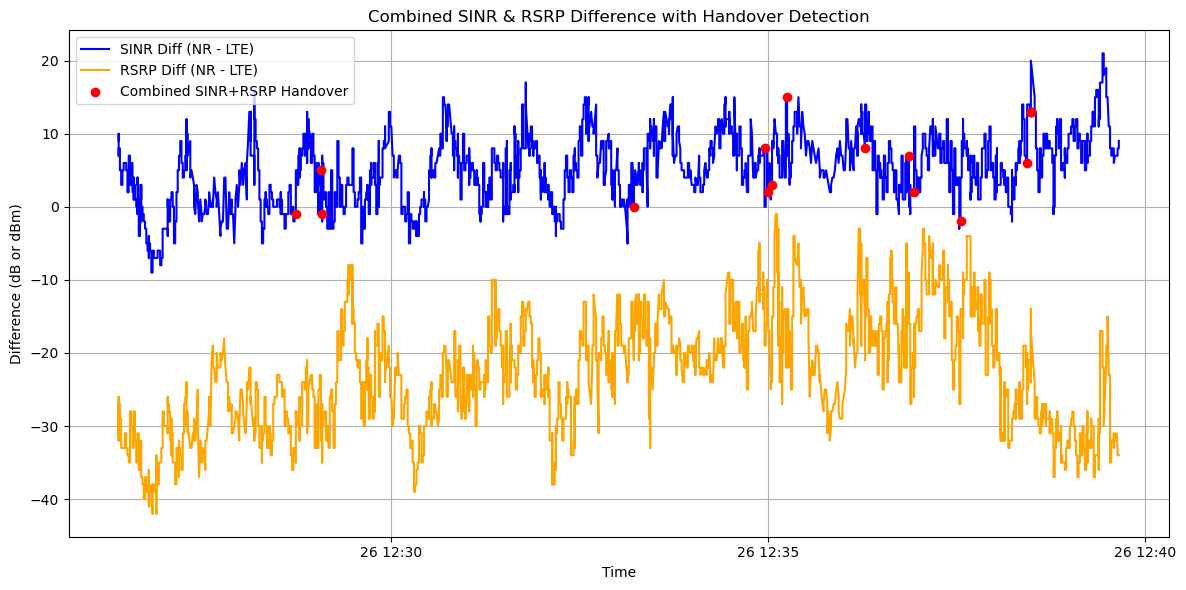

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate SINR and RSRP differences
df["SINR_Diff"] = df["NR_SINR"] - df["LTE_SINR"]
df["RSRP_Diff"] = df["NR_RSRP"] - df["LTE_RSRP"]

# Compute time-based difference for change detection
df["SINR_Change"] = df["SINR_Diff"].diff().abs()
df["RSRP_Change"] = df["RSRP_Diff"].diff().abs()

# Define joint threshold condition
combined_handover_points = df[(df["SINR_Change"] > 5) & (df["RSRP_Change"] > 6)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df["Time and date"], df["SINR_Diff"], label="SINR Diff (NR - LTE)", color='blue')
plt.plot(df["Time and date"], df["RSRP_Diff"], label="RSRP Diff (NR - LTE)", color='orange')

# Highlight combined handover triggers
plt.scatter(combined_handover_points["Time and date"], combined_handover_points["SINR_Diff"],
            color='red', label="Combined SINR+RSRP Handover", zorder=5)

plt.title("Combined SINR & RSRP Difference with Handover Detection")
plt.xlabel("Time")
plt.ylabel("Difference (dB or dBm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

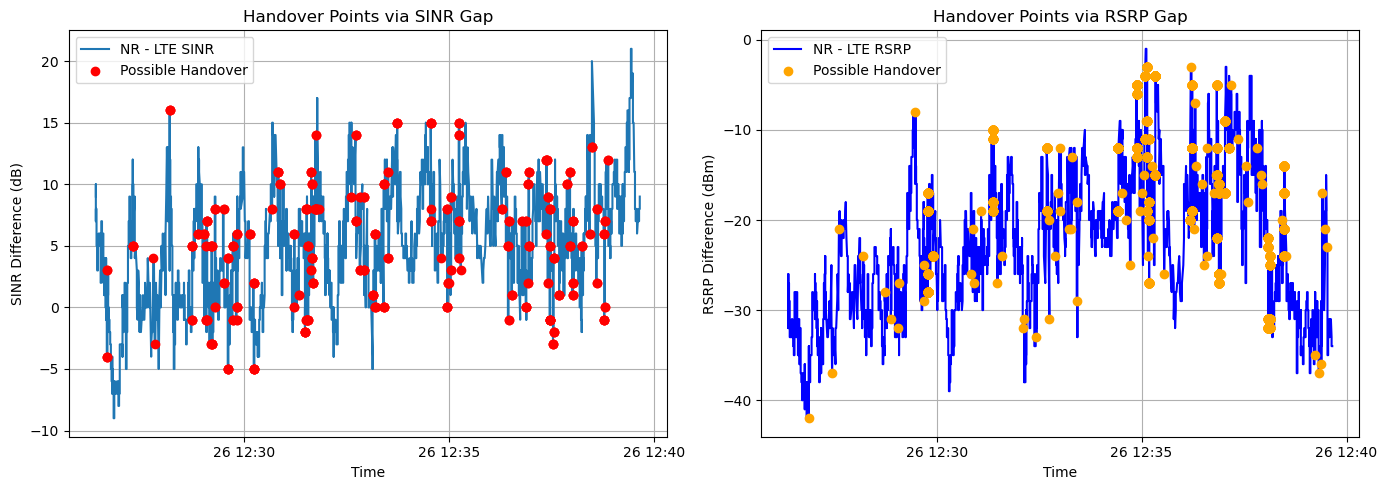

In [4]:
# Identify significant switches in technology via SINR and RSRP differences
df["SINR_Diff"] = df["NR_SINR"] - df["LTE_SINR"]
df["RSRP_Diff"] = df["NR_RSRP"] - df["LTE_RSRP"]

# Threshold-based handover detection
sinr_handover_points = df[df["SINR_Diff"].diff().abs() > 5]
rsrp_handover_points = df[df["RSRP_Diff"].diff().abs() > 6]  # Adjust threshold as needed

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# SINR difference plot
plt.subplot(1, 2, 1)
plt.plot(df["Time and date"], df["SINR_Diff"], label="NR - LTE SINR")
plt.scatter(sinr_handover_points["Time and date"], sinr_handover_points["SINR_Diff"],
            color='red', label="Possible Handover", zorder=5)
plt.title("Handover Points via SINR Gap")
plt.xlabel("Time")
plt.ylabel("SINR Difference (dB)")
plt.grid(True)
plt.legend()

# RSRP difference plot
plt.subplot(1, 2, 2)
plt.plot(df["Time and date"], df["RSRP_Diff"], label="NR - LTE RSRP", color='blue')
plt.scatter(rsrp_handover_points["Time and date"], rsrp_handover_points["RSRP_Diff"],
            color='orange', label="Possible Handover", zorder=5)
plt.title("Handover Points via RSRP Gap")
plt.xlabel("Time")
plt.ylabel("RSRP Difference (dBm)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()